In [3]:
import os
import sys

import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

sys.path.append(os.path.join(os.getcwd(),os.pardir))
from src.data.load_preprocess_data import load_and_preprocess_raw_complaints_data

data_path = os.path.join(os.pardir, "data", "raw", "complaints.csv")
if os.path.exists(data_path):
    complaints_df = load_and_preprocess_raw_complaints_data(data_path)
else:
    raise FileNotFoundError('Data is not downloaded or not in the correct folder.')

## Inspection


- We can see that the interested target only has 768443 valid values, under which we want to trim the data frame to have null dispute responses removed.
- We can drop non-useful features like `zip_code` and `complaint_id`.
- It seems that we can process the `consumer_complaint_narrative` using NLP and other useful features using `OneHotEncoder` (apply binary encoding if necessary) since the unique values of most of the features are not too many.

In [4]:
unique_df = pd.DataFrame()
unique_df['columns'] = complaints_df.columns
unique_df['valid_count'] = complaints_df.count(axis=0).reset_index()[0]
unique_df['unique_count'] = complaints_df.nunique().reset_index()[0]
unique_df

,columns,valid_count,unique_count
0,date_received,3101969,4011
1,product,3101969,18
2,sub_product,2866675,76
3,issue,3101969,165
4,sub_issue,2418614,221
5,consumer_complaint_narrative,1113992,973058
6,company_public_response,1348784,11
7,company,3101969,6572
8,state,3061948,63
9,zip_code,3061429,34445


## Missing Values

In [5]:
num_complaints = 2000
alt.data_transformers.enable('data_server')
na_val_df = complaints_df.tail(num_complaints).isna().reset_index().melt(
        id_vars='index'
    )
last_date = complaints_df.date_received.tail(num_complaints).max().strftime("%m/%d/%Y")
first_date = complaints_df.date_received.tail(num_complaints).min().strftime("%m/%d/%Y")

missing_vals = alt.Chart(
    complaints_df.tail(num_complaints).isna().reset_index().melt(
        id_vars='index'
    ),
    title = f"Missing Values of {num_complaints} Complaints: {first_date} - {last_date}"
).mark_rect().encode(
    alt.X('index:O', axis=None),
    alt.Y('variable', title=None),
    alt.Color('value', title='Missing Value',scale=alt.Scale(scheme='dark2')),
    alt.Stroke('value', scale=alt.Scale(scheme='dark2'))  # We set the stroke which is the outline of each rectangle in the heatmap
).properties(
    width=min(500, complaints_df.tail(num_complaints).shape[0])
);
display(missing_vals)

alt.Chart(...)

- From the graph below, we see an imbalanced class, which we should take into account during later training of the model.

In [6]:
# complaints_df = complaints_df.query('not consumer_disputed.isnull()')
complaints_df.head()
target = pd.DataFrame(complaints_df.value_counts('consumer_disputed')).reset_index()
target.columns = ['consumer_disputed','count']
alt.Chart(
    target,
    title = "Majority of Complaints are Not Disputed"
).mark_bar().encode(
    y=alt.Y('consumer_disputed:O',title = 'Consumer Disputed'),
    x=alt.X('count:Q',title = 'No. of Complaints'),
    color=alt.Color('consumer_disputed:O', legend=None),
).properties(
    width = 600,
    height = 300
)

alt.Chart(...)

## Wordcloud of Customer Review

Here we show two visualizations of what customers mentioned for their complaints in disputed/non-disputed classes.

Comparing the Most common words in issues between disputed and undisputed consumers:


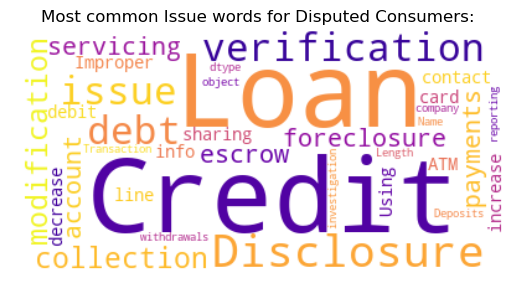

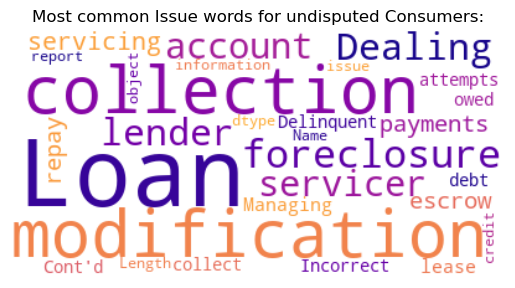

In [7]:
stopwords = set(STOPWORDS)
disputed_words = str(complaints_df['issue'].loc[complaints_df['consumer_disputed'] == 'Yes'])
undisputed_words = str(complaints_df['issue'].loc[complaints_df['consumer_disputed'] == 'No'])
print("\033[1mComparing the Most common words in issues between disputed and undisputed consumers:\033[0m")

plt.title("Most common Issue words for Disputed Consumers:")
wordcloud = WordCloud(background_color="white", collocations=False, colormap='plasma', max_words=100).generate(disputed_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.title("Most common Issue words for undisputed Consumers:")
wordcloud = WordCloud(background_color="white", collocations=False, colormap='plasma', max_words=100).generate(undisputed_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Insights

- from July 2022 to November no consumers were recorded as disputing a claim, potentially because they haven't been processed yet?
- what about older claims?

In [8]:
complaints_df = load_and_preprocess_raw_complaints_data(data_path)
num_complaints = complaints_df.resample("M", on="date_received").agg({'date_received': 'size'}).rename(columns={"date_received":"num_complaints"}).reset_index()

alt.Chart(
    num_complaints,
    title = "Monthly Complaints are Spiking in 2022"
).mark_line().encode(
	x = alt.X('date_received:T', title="Date Complaints Received"),
	y = alt.Y("num_complaints:Q", title = "No. of Monthly Complaints") 
).properties(
    width = 700,
    height = 400
)

alt.Chart(...)

## Complaints by Product

In [9]:
proc_complaints_df = complaints_df.copy(deep=True)
proc_complaints_df["year_month"] = proc_complaints_df.date_received.apply(lambda dt: dt.replace(day=1))
alt.Chart(
    proc_complaints_df.groupby(['year_month', "product"], as_index=False).agg(
        num_complaints = ("product", "size")
    ),
    title = "Credit Reporting & Credit Repairs Service Complaints Make Up the Majority of Complaints"
).mark_line().encode(
	x = alt.X('year_month:T', title="Date Complaints Received"),
	y = alt.Y("num_complaints", title = "No. of Monthly Complaints"),
    color = "product",
    tooltip="product"
).properties(
    width = 600,
    height = 400
).interactive()

alt.Chart(...)

In [10]:
most_complaint_types = (
    proc_complaints_df.groupby(["product"], as_index=False)
    .agg(num_complaints = ("product", "size"))
    .sort_values(by = "num_complaints", ascending=False)
    .head(6)["product"]
    .to_list()
)

most_complaint_types = list(filter(lambda x: not x.startswith("Credit reporting, credit repair"), most_complaint_types))

alt.Chart(
    proc_complaints_df.loc[proc_complaints_df["product"].isin(most_complaint_types), :].groupby(['year_month', "product"], as_index=False).agg(
    num_complaints = ("product", "size")
    ),
    title = "Top 5 Most Common Products (Excluding Credit Reporting & Credit Repair)"
).mark_line().encode(
	x = alt.X('year_month:T', title="Date Complaints Received"),
	y = alt.Y("num_complaints", title = "No. of Monthly Complaints"),
    color = "product",
    tooltip="product"
).properties(
    width = 600,
    height = 400
).interactive()

alt.Chart(...)

In [11]:
least_complaint_types = (
    proc_complaints_df.groupby(["product"], as_index=False)
    .agg(num_complaints = ("product", "size"))
    .sort_values(by = "num_complaints", ascending=True)
    .head(5)["product"]
    .to_list()
)

alt.Chart(
    proc_complaints_df.loc[proc_complaints_df["product"].isin(least_complaint_types), :].groupby(['year_month', "product"], as_index=False).agg(
    num_complaints = ("product", "size")
    ),
    title = "Top 5 Least Common Products with Complaints"
).mark_line().encode(
	x = alt.X('year_month:T', title="Date Complaints Received"),
	y = alt.Y("num_complaints", title = "No. of Monthly Complaints"),
    color = "product",
    tooltip="product"
).properties(
    width = 600,
    height = 400
).interactive()

alt.Chart(...)

# Complaints by Company

In [12]:
alt.Chart(
    proc_complaints_df.groupby(['year_month', "company"], as_index=False).agg(
        num_complaints = ("company", "size")
    ),
    title = "Majority of Complaints are from TransUnion, Experian & Equifax"
).mark_line().encode(
	x = alt.X('year_month:T', title="Date Complaints Received"),
	y = alt.Y("num_complaints", title = "No. of Monthly Complaints"),
    color = "company",
    tooltip="company"
).properties(
    width = 800,
    height = 400
).interactive()

alt.Chart(...)

Insight: looks like majority of compalints come from 3 companies

## Top 6 Companies by Number of Complaints

In [13]:
most_complaint_types = (
    proc_complaints_df.groupby(["company"], as_index=False)
    .agg(num_complaints = ("company", "size"))
    .sort_values(by = "num_complaints", ascending=False)
    .head(6)["company"]
    .to_list()
)

alt.Chart(
    proc_complaints_df.loc[proc_complaints_df["company"].isin(most_complaint_types), :].groupby(['year_month', "company"], as_index=False).agg(
    num_complaints = ("company", "size")
    ),
    title = "Top 5 Most Common Companys"
).mark_line().encode(
	x = alt.X('year_month:T', title="Date Complaints Received"),
	y = alt.Y("num_complaints", title = "No. of Monthly Complaints"),
    color = "company",
    tooltip="company"
).properties(
    width = 800,
    height = 400
).interactive()

alt.Chart(...)

Insight: Top 3 Companies with Most Complaints: Equifax, TransUnion, Experian